In [465]:
import plio
from plio.io.io_gdal import GeoDataset
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import gdal 
from os import path
import osr 

rcParams['figure.figsize'] = 15,10

# nans everywhere
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [497]:
# data = '/work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/Landsat_8_C1/2013/2013-11-10-n_165198/SensorRad_C1/'
data = '/data/landsat8/SensorRad_C1/'
def modvolc(mir, tir, thresh=-.8):
    """
    """
    nti = (mir - tir)/(mir + tir)
    
    anomolies = np.empty(nti.shape)
    anomolies[:] = False
    anomolies[np.isnan(nti)] = np.nan
    anomolies[nti >= thresh] = True
    return anomolies, nti


def hash_dataset(dataset):
    if isinstance(dataset, str):
        dataset = GeoDataset(dataset)
    
    string = ""
    string += str(b7.geotransform)
    string += str(b7.spatial_reference)
    string += str(b7.xy_corners)
    string += str(b7.latlon_extent)
    for band in range(1,dataset.nbands+1):
        arr = dataset.read_array(band)
        string += "Band {}\n".format(band)
        string += str(round(np.min(arr), 3))
        string += str(round(np.max(arr), 3))
        string += str(round(np.sum(arr), 3))
    
    del dataset 
    sha1 = hashlib.sha1(string.replace(' ', '').replace('\n','').encode()).hexdigest()
    return sha1



def crop(cropfile, extents, use_latlon=True):
    """
    Uses the virtual file system: http://www.gdal.org/gdal_virtual_file_systems.html
    """
    # hash the image info to get the filename
    filename = hash_dataset(cropfile)
    
    if use_latlon:
        ul = np.asarray(cropfile.latlon_to_pixel(extents[0], extents[1]))
        lr = np.asarray(cropfile.latlon_to_pixel(extents[2], extents[3]))
        window_size = np.abs(ul-lr)
        extents = [ul[0], ul[1], window_size[0], window_size[1]]
    
    clip = gdal.Translate(path.join('/vsimem', filename), cropfile.file_name, srcWin=extents)
    return GeoDataset(clip.GetDescription())


def pixels_to_latlon(geodataset, locs):
    coords = []
    for loc in locs:
        coords.append(geodataset.pixel_to_latlon(loc[1], loc[0]))
    return coords


def to_geodataset(dataset):
    if not isinstance(dataset, GeoDataset):
        return GeoDataset(path.abspath(dataset.GetDescription()))
    return dataset
    

def info(file, **kwargs):
    file = to_geodataset(file)
    
    showFileList = kwargs.pop('showFileList', False)
    
    string = "{}\n".format(gdal.Info(file.file_name, showFileList=False, showColorTable=False, showMetadata=False, **kwargs))
    return string


def array2raster(rasterfn,array,newRasterfn=None):
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    cols = raster.RasterXSize
    rows = raster.RasterYSize

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def write_array(dataset, array, out=None):
    naxis = len(array.shape)
    assert naxis == 2 or naxis == 3      
    
    if naxis == 2:
        # exapnd the third dimension
        array = array[:,:,None]
    
    nbands = array.shape[2]
    
    if nbands > dataset.nbands:
        for i in range(nbands-dataset.nbands):
            dataset.dataset.AddBand()
    
    if out:
        # copy the file 
        new_dataset = gdal.Translate(out, dataset.file_name)
        for band in range(nbands):
            outBand = new_dataset.GetRasterBand(band+1)
            outBand.WriteArray(array[:,:,band])
        del new_dataset
        return GeoDataset(out)
    
    # Else use virtual filesystem
    temp = gdal.Translate('/vsimem/temp', dataset.file_name)
    for band in range(nbands):
        outBand = temp.GetRasterBand(band+1)
        outBand.WriteArray(array[:,:,band])

    # copy file into proper name and delete temp
    del temp
    return to_geodataset(gdal.Translate(path.join('/vsimem/', hash_dataset('/vsimem/temp')), '/vsimem/temp'))
        

In [444]:
b7 = crop(GeoDataset(data+'LC08_L1GT_166197_20131117_20170428_01_T2_B7_SensorRad.TIF'), [19.445, -155.321, 19.343,-155.164])
b11 = crop(GeoDataset(data+'LC08_L1GT_166197_20131117_20170428_01_T2_B11_SensorRad.TIF'), [19.445, -155.321, 19.343,-155.164])
b10 = crop(GeoDataset(data+'LC08_L1GT_166197_20131117_20170428_01_T2_B10_SensorRad.TIF'), [19.445, -155.321, 19.343,-155.164])

b11arr = b11.read_array()
b11arr[b11arr == 0] = np.nan

b10arr = b10.read_array()
b10arr[b10arr == 0] = np.nan

b7arr = b7.read_array()
b7arr[b10arr == 0] = np.nan


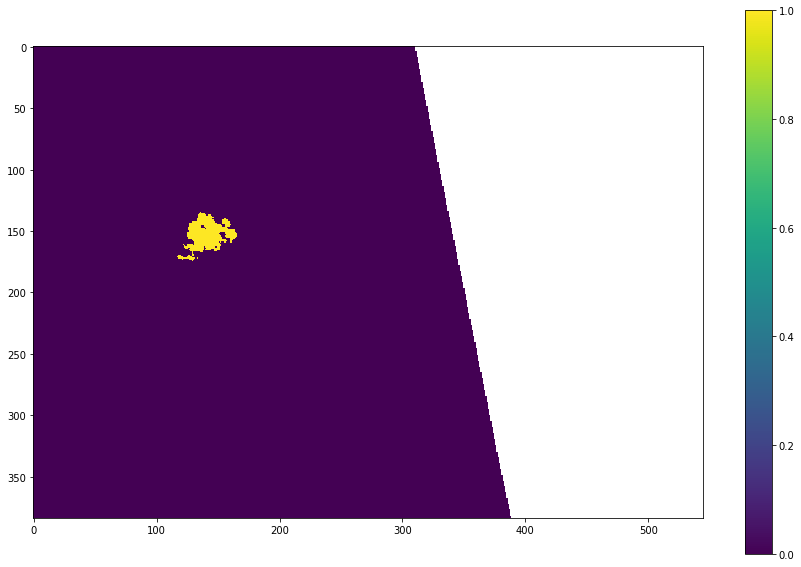

In [490]:
anomolies, nti = modvolc(b7arr, b10arr, thresh=-.8)
plt.imshow(anomolies)
plt.colorbar()

In [467]:
latlons = pixels_to_latlon(b7, np.argwhere(anomolies==True))
latlons[:10]

[(19.409139570755084, -155.2817920551586),
 (19.40886508109506, -155.28207378786738),
 (19.40886866837841, -155.2817882746023),
 (19.408872255213794, -155.2815027612739),
 (19.4088758416012, -155.2812172478823),
 (19.408879427540644, -155.28093173442744),
 (19.40859059108625, -155.2823555196321),
 (19.40859417876359, -155.28207000690227),
 (19.40859776599296, -155.2817844941092),
 (19.408601352774376, -155.28149898125287)]

In [509]:
b7.dataset.AddBand?
anom_dataset = write_array(b7, anomolies, out='anomolies.tif')


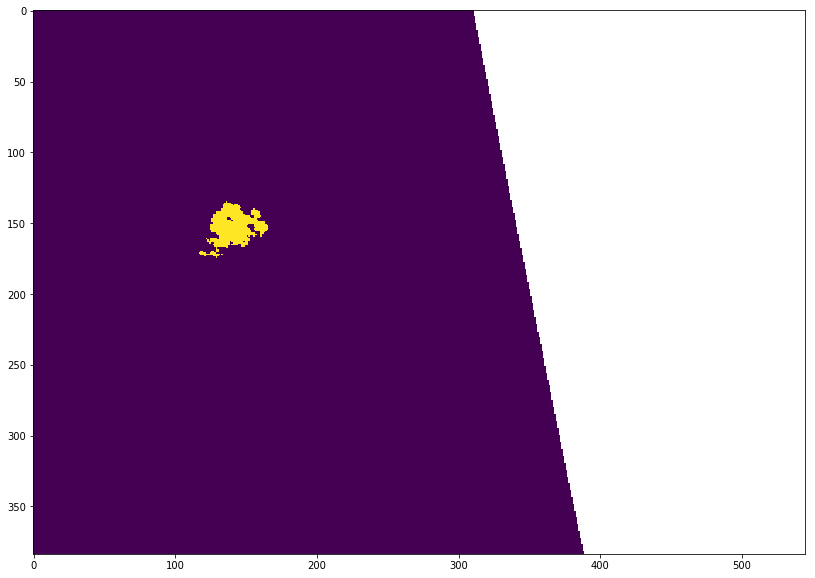

In [510]:
test = GeoDataset('anomolies.tif')
plt.imshow(anom_dataset.read_array(1))

In [515]:
b7.dataset.AddBand()

RuntimeError: /vsimem/acd9463d46072f57575ae1fd2b4add271098af57: Dataset does not support the AddBand() method.